# Lesson 6: Essay Writer

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()


In [2]:
from setup_environment_r2 import set_environment_variables
set_environment_variables('Essay-Writing-deeplearning.ai')

reading environment variables from: </home/tjamil/Desktop/Agents/code_excercises/Langgraph/Ai Agents using Langgraph (dl.ai)>
API Keys loaded and tracing set with project name:  Essay-Writing-deeplearning.ai


In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from IPython.display import Image, display
import sqlite3
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)

#memory = SqliteSaver.from_conn_string(":memory:")

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
#from langchain_openai import ChatOpenAI
#model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

from utils import GroqChatLLM, OllamaLLM
#model2 = GroqChatLLM(model_name='llama3-8b-8192')
model2 = OllamaLLM(model_name='gemma2:2b')
model = GroqChatLLM(model_name='llama3-70b-8192')
model.invoke("hello")  # testing

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.08135383, 'prompt_time': 0.000181979, 'queue_time': 0.014242409999999999, 'total_time': 0.081535809}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'stop', 'logprobs': None}, id='run-18ae0629-ca2d-4b61-90be-f2a5ec27d23b-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [10]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [11]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

/home/tjamil/Desktop/Agents/.conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [13]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [14]:
def research_plan_node(state: AgentState):

    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    
    content = state.get('content', []) #or state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [15]:
def generation_node(state: AgentState):
    
    content = "\n\n".join(state.get('content', [])) #or state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model2.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [16]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [17]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state.get('content', []) #or state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [18]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [19]:
builder = StateGraph(AgentState)

In [20]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

In [23]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [24]:
graph = builder.compile(checkpointer=memory)

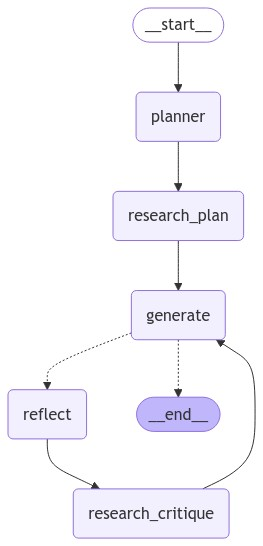

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    #'task': "what is the difference between langchain and langsmith",
    'task': "Write an Assay on AI use case in Education Exams assessment?",
    
    "max_revisions": 2,
    "revision_number": 1,}, thread):
    print(s)

{'planner': {'plan': 'Here is a high-level outline for an essay on AI use cases in education exams assessment:\n\n**Title:** "Revolutionizing Education Exams: The Role of Artificial Intelligence in Assessment"\n\n**I. Introduction**\n\n* Brief overview of the importance of education and the need for efficient assessment methods\n* Thesis statement: Artificial Intelligence (AI) has the potential to transform the way we assess student learning, making exams more efficient, accurate, and personalized.\n\n**II. Current Challenges in Education Exams Assessment**\n\n* Discuss the limitations of traditional assessment methods (e.g., human grading, paper-based exams)\n* Highlight the issues of bias, subjectivity, and time-consuming grading processes\n* Introduce the need for innovative solutions to address these challenges\n\n**III. AI-Powered Assessment: Use Cases in Education Exams**\n\n* **Automated Grading**: Explain how AI can accurately grade exams, freeing up instructors\' time and redu

In [27]:
thread = {"configurable": {"thread_id": "1"}}

result = graph.invoke({
    #'task': "what is the difference between langchain and langsmith",
    'task': "Write an Assay on AI use case in Education Exams assessment?",
    "max_revisions": 2,
    "revision_number": 1,}, thread)

print(result)

{'task': 'Write an Assay on AI use case in Education Exams assessment?', 'plan': 'Here is a high-level outline for an essay on AI use cases in education exams assessment:\n\n**Title:** "Revolutionizing Education Exams: The Role of Artificial Intelligence in Assessment"\n\n**I. Introduction**\n\n* Brief overview of the importance of education and the need for efficient assessment methods\n* Thesis statement: Artificial Intelligence (AI) has the potential to transform the way we assess student learning, making exams more efficient, accurate, and personalized.\n\n**II. Current Challenges in Education Exams Assessment**\n\n* Discuss the limitations of traditional assessment methods (e.g., human grading, paper-based exams)\n* Highlight the issues of bias, subjectivity, and time-consuming grading processes\n* Introduce the need for innovative solutions to address these challenges\n\n**III. AI-Powered Assessment: Use Cases in Education Exams**\n\n* **Automated Grading**: Explain how AI can ac

In [33]:
from pprint import pprint

pprint(result['content'], width=120)

['AI agents are more than chatbots or content generators; they can take action, complete tasks and drive real-world '
 'results. To better automate and enhance business operations, you can use AI agents to iteratively prompt language '
 'models with revised context from previous outputs, mirroring and accelerating human processes. The AI agents analyze '
 'data from multiple sources, including customer interactions, inventory and market trends, to make real-time '
 'decisions. Key first steps for business leaders looking to adopt AI agents are: This helps validate that your pilot '
 'projects are resulting in outcomes aligned with your business objectives before you scale AI agents across broader '
 'functions. Overall, my advice to business leaders is simple: Start exploring AI agents now.',
 'Beyond Bots: How AI Agents Are Driving the Next Wave of Enterprise Automation Unlike previous generations of '
 'software that primarily addressed low-level, sequential tasks that could be robot

## Essay Writer Interface

#run notebook 'Test6_gradio.ipynb'